In [35]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import useful_functions as uf
import density as den
import constants as cc
from scipy.interpolate import interp1d
import sys
sys.path.insert(0,'/home/zahra/hirax_tools/hirax_tools')
from array_config import HIRAXArrayConfig
from scipy.integrate import trapz, cumtrapz
import pylab
from matplotlib.colors import LogNorm
from SKA_noise import SKA_dish_interferom

In [36]:
cosmo=uf.cosmo

Mps_interpf=uf.Mps_interpf

n_points=40
n=n_points
z_r=10

x_e=1.

G=cc.G_const_Mpc_Msun_s/cc.M_sun_g

#rho_c=3*H0**2/(8.*np.pi*G)

rho_c=den.cosmo_densities(**cosmo)[0]*cc.M_sun_g #in units of g/Mpc^3

sigma_T=cc.sigma_T_Mpc

tau_r=0.055

T_rad=2.725 #In Kelvin
#tau_r=0.046*omega_b_0*h*x_e[np.sqrt(omega_M_0(1+z_r)**3+(1-omega_M_0))-1]

#get matter power spec data

mu_e=1.14

m_p=cc.m_p_g #in grams

rho_g0=cosmo['omega_b_0']*rho_c

#plt.loglog(uf.kabs,Mps_interpf(uf.kabs))

#plt.show()
zed=uf.zed

H=uf.H
chi=uf.chi
#chi_Z=chi(Z)
tau_inst=uf.tau_inst
f=uf.f
D=uf.D_1
r=uf.r

repl_zero_number=1.e-6

z_c=1.
delta_z=0.2

min_bls_hirax=6.

min_bls_ska=14.62

c_light_m_s=cc.c_light_cm_s/100

max_bls_hirax=31*min_bls_hirax*np.sqrt(2)*2*np.pi*700*1.e6/c_light_m_s

max_bls_ska=16*min_bls_ska*np.sqrt(2)*2*np.pi*700*1.e6/c_light_m_s

kperp_lims=uf.ell_lims(z_c,min_bls_ska,max_bls_ska)/uf.chi(z_c)
kpar_min_lim=uf.kpar_min(z_c,delta_z)

#kpperp_min=kperp_lims[0]
#kpperp_max=kperp_lims[1]
kpperp_min=5.e-4 #tested and confirmed to be a good limit
kpperp_max=1. #tested and confirmed to be a good limit
kppar_min=1.e-3 #tested and confirmed to be a good limit
kppar_max=1.

kperp_min=5.e-4
kperp_max=5.
kpar_min=1.e-3
kpar_max=1.

In [37]:
#ell=np.geomspace(2.,1.e4,n_points)
#kperp_arr=ell/chi(z_c)
kperp_arr=np.geomspace(kperp_min,kperp_max,n_points)
kpar_arr=np.geomspace(kpar_min,kpar_max,n_points)
ell=kperp_arr*chi(z_c)
y=kpar_arr*r(z_c)
print uf.ell_lims(z_c,min_bls_hirax, max_bls_hirax)/uf.chi(z_c)

[ 0.01810615 11.64554798]


In [38]:

#kpar_min=uf.kpar_min(z,delta_z)

def ionized_elec(Yp,N_He):

    x=(1-Yp*(1-N_He/4))/(1-Yp/2)

    return x


x=ionized_elec(0.24,0)


In [39]:
Cl_ksz=np.load('C_l_ksz_z_1_full_100pts_2d_2_1e5.npy')
ell_loaded=Cl_ksz[0,:]
Cl_ksz_full_arr=Cl_ksz[1,:]
OV_interp=interp1d(ell_loaded,Cl_ksz_full_arr)

In [40]:
cmb_spec=np.load('cmb_spec_2_1e5_50000pts.npy')
cmb_noise=np.load('cmb_noise_2_1e5_50000pts.npy')
ell_cmb=cmb_spec[0,:]
cmb_spec_loaded=cmb_spec[1,:]
cmb_noise_loaded=cmb_noise[1,:]

cmb_spec_interp=interp1d(ell_cmb,cmb_spec_loaded)
cmb_noise_interp=interp1d(ell_cmb,cmb_noise_loaded)

In [41]:
loaded_fourier_arr=np.load('nu_and_kpar_fourier_dchi2_int_full_redshift_10000pts.npy')

nu=loaded_fourier_arr[0,:]
f_of_kpar_func=loaded_fourier_arr[1,:]

kpar_fourier_dchi2_int=interp1d(nu,f_of_kpar_func)

def crosscorr_fourier(ell,z,y, delta_z,kp_perp,kp_par): #with the assumption that zi=z so no cos factor, and we have dz=redshift bin width=2*delta_z defined above
    n=n_points #number of points over which to integrate
    #y=np.geomspace(1.,3000.,n)
    T_mean_zi=uf.T_mean(z)
    chi_zi=chi(z)
    f_zi=uf.f(z)
    D_zi=uf.D_1(z)
    r_zi=uf.r(z)
    H_zi=uf.H(z)
    kpar=y/uf.r(z)
    const=1.e6/(4.*np.pi**2)*T_rad*T_mean_zi**2/cc.c_light_Mpc_s*f_zi*D_zi**2*H_zi/(chi_zi**2*r_zi)/(1.+z)*x*(sigma_T*rho_g0/(mu_e*m_p))
    #Cl=np.array([])
    k_perp=ell/chi_zi
    k=np.sqrt(k_perp**2+kpar**2)
    rsd=1.+f_zi*kpar**2/k**2
    kp=np.sqrt(kp_perp**2+kp_par**2)
    cos_theta=kp_par/kp #cos_theta=u, theta is azimuthal angle between k' and z (line of sight) axis
    sin_theta=kp_perp/kp
    sin_gamma=kpar/k #gamma is measured between k and xy plane, i.e. elevation of k
    cos_gamma=k_perp/k
    zeta=sin_gamma*cos_theta+cos_gamma*sin_theta
    k_dot_kp=k_perp*kp_perp+kpar*kp_par#*zeta
    k_perp_dot_kp_perp=k_perp*kp_perp
    K=np.sqrt(k**2+kp**2-2*k_dot_kp)
    K=np.where(K==0, repl_zero_number, K)   
    K_perp=np.sqrt(np.abs(k_perp**2+kp_perp**2-2*k_perp_dot_kp_perp))
    K_perp=np.where(K_perp==0, repl_zero_number, K_perp)
    #theta_K=kpar/K/k**2*(k**2-k_dot_kp)-kp*k_perp*np.sqrt(np.abs(1-zeta**2))/k/K
    theta_K=(np.abs(kpar-kp_par))/K
    theta_kp=cos_theta
    z_integral=np.abs(kpar_fourier_dchi2_int(kpar))
    #theta_kp=kpar*zeta/k+k_perp*np.sqrt(np.abs(1-zeta**2))/k
    #print (theta_K.min(),theta_K.max())
    #theta_K=np.where(theta_K > 0, theta_K, 0)
    I=theta_kp*(theta_kp/kp**2+theta_K/K/kp)
    #z_integral=sp.integrate.trapz(f_z*D_z**2*(1+z)*np.exp(-tau_z)*np.cos(kpar*cc.c_light_Mpc_s*z/H_z),z)
    integrand_1=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp**2*kp_perp/kp**2
  #+theta_K/K/kp)#-mu*kp*np.gradient(Mps_interpf(k),axis=0))
    integrand_2=z_integral*Mps_interpf(kp)*Mps_interpf(K)*rsd**2*theta_kp*theta_K*kp_perp/kp/K

    #Cl=np.append(Cl,integral)
    return const*(integrand_1+integrand_2)



In [42]:
def Func_2d_redshift(ell,z_arr,y,Func,delta_z):
    Func_mat=np.zeros((len(z_arr),len(ell),len(y)))
    for z_ind in range(len(z_arr)):
        for i in range(len(ell)):
            for j in range(len(y)):
                Func_ind=Func(ell[i],z_arr[z_ind],y[j],delta_z)
                Func_mat[z_ind][i][j]=Func_ind
    return Func_mat


def Func_noise_redshift_slow(ell,z_arr,y,Func,delta_z,Noise):
    Func_mat=np.zeros((len(z_arr),len(ell),len(y)))
    for z_ind in range(len(z_arr)):
        for i in range(len(ell)):
            for j in range(len(y)):
                Func_ind=Func(ell[i],z_arr[z_ind],y[j],delta_z,Noise)
                Func_mat[z_ind][i][j]=Func_ind       
    return Func_mat


def Func_noise(ell,z_c,y,Func,delta_z,Noise):
    Func_mat=np.zeros((len(ell),len(y)))
    for i in range(len(ell)):
        for j in range(len(y)):
            Func_ind=Func(ell[i],z_c,y[j],delta_z,Noise)
            Func_mat[i][j]=Func_ind
    return Func_mat


In [43]:
def Signal_integrated_fourier(ell,z,y,delta_z):
    Kp_perp=np.geomspace(kpperp_min,kpperp_max,n)
    Kp_par=np.geomspace(kppar_min,kppar_max,n)
    kp_perp,kp_par=np.meshgrid(Kp_perp,Kp_par)
    B=crosscorr_fourier(ell,z,y, delta_z,kp_perp,kp_par)
    integral=trapz(trapz(B,Kp_perp,axis=0),Kp_par,axis=0)
    integral_sqrt=np.sqrt(np.abs(integral))
    return integral

def Signal_2d(ell,z_c,y,delta_z):
    Z_min=z_c-delta_z
    Z_max=z_c+delta_z
    z_arr=np.geomspace(Z_min,Z_max,n)
    return trapz(Func_2d_redshift(ell,z_arr,y,Signal_integrated_fourier,delta_z),z_arr,axis=0)



In [44]:
def HiraxNoise(l,Ddish,Dsep,zi,delta_z): #the Dsep refers to the dish seperation including the dish diameter of 6. So we're assuming dishes are 1m away
        z_min=zi-delta_z
        z_max=zi+delta_z
        nu_21=1420
        nu_min=nu_21/(1+z_max) #743. #585. # #freq in MHz, these min and max values are based on HIRAX
        nu_max=nu_21/(1+z_min)#784. #665. #
        cp= HIRAXArrayConfig.from_n_elem_compact(1024,Dsep)
        nubar=(nu_min+nu_max)/2.

        Fov_deg=(cp.fov(frequency=nubar)) * ((180./np.pi)**2)
        Fov_str=(cp.fov(frequency=nubar))
        Tsys= 50. + 60.*((nubar/300.)**-2.5)
        lam=3.e8/(nubar*1.e6)
        Nbeam=1.
        npol=2.
        nu21=1420.e6
        Aeff=np.pi*((Ddish/2.)**2)*0.67
        Ttot=100.8e6 #36e6   4*365*24*3600.
        #Ttot=2*365*24*3600
        Sarea=15000.
        pconv=(chi(zi)**2)*r(zi)
        n_u=cp.baseline_density_spline(frequency=nubar)
        n=np.array([])
        for i in l:
            if n_u(i/(2.*np.pi))==0:
                n_u1=1/1e10
            else:
                n_u1=n_u(i/(2.*np.pi))
            n=np.append(n,n_u1)
        Nbs= 1024.*(1024.-1.)
        #norm=Nbs/sp.integrate.trapz(n*2*np.pi*(l/(2.*np.pi)), l/(2.*np.pi))
        C=n#*noprint (nu_min)
        A_bull= ((Tsys**2)*(lam**4)*Sarea) / (nu21*npol*Ttot*(Aeff**2)*Fov_deg*Nbeam)
        Warren=Tsys**2*lam**2/Aeff*4.*np.pi/(nu21*npol*Nbeam*Ttot)
        #return (Warren/C)*1e12
        return (A_bull/C)*1e12

ell_large=np.geomspace(1.e-4,1.e6,10000)

Hirax_noise_z_1_deltaz_pt2 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,1.,0.2), bounds_error=False)


Hirax_noise_z_2_deltaz_pt2 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,2.,0.2), bounds_error=False)

Hirax_noise_z_2_deltaz_pt4 = interp1d(ell_large, HiraxNoise(ell_large,6.,7.,2.,0.4), bounds_error=False)


#Noise=Hirax_noise_z_1pt26_deltaz_pt0015
Noise=Hirax_noise_z_1_deltaz_pt2


In [45]:
file_dish_z_2pt86=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_86.dat',dtype=float,unpack=True)
file_interferom_z_2pt86=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_86.dat',dtype=float,unpack=True)
file_dish_z_2pt76=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_76.dat',dtype=float,unpack=True)
file_interferom_z_2pt76=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_76.dat',dtype=float,unpack=True)
file_dish_z_2pt66=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_66.dat',dtype=float,unpack=True)
file_interferom_z_2pt66=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_66.dat',dtype=float,unpack=True)
file_dish_z_2pt56=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_56.dat',dtype=float,unpack=True)
file_interferom_z_2pt56=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_56.dat',dtype=float,unpack=True)
file_dish_z_2pt46=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_46.dat',dtype=float,unpack=True)
file_interferom_z_2pt46=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_46.dat',dtype=float,unpack=True)
file_dish_z_2pt36=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_36.dat',dtype=float,unpack=True)
file_interferom_z_2pt36=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_36.dat',dtype=float,unpack=True)
file_dish_z_2pt26=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_26.dat',dtype=float,unpack=True)
file_interferom_z_2pt26=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_26.dat',dtype=float,unpack=True)
file_dish_z_2pt16=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_16.dat',dtype=float,unpack=True)
file_interferom_z_2pt16=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_16.dat',dtype=float,unpack=True)
file_dish_z_2pt06=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_2_06.dat',dtype=float,unpack=True)
file_interferom_z_2pt06=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_2_06.dat',dtype=float,unpack=True)
file_dish_z_1pt96=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_96.dat',dtype=float,unpack=True)
file_interferom_z_1pt96=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_96.dat',dtype=float,unpack=True)
file_dish_z_1pt86=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_86.dat',dtype=float,unpack=True)
file_interferom_z_1pt86=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_86.dat',dtype=float,unpack=True)
file_dish_z_1pt76=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_76.dat',dtype=float,unpack=True)
file_interferom_z_1pt76=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_76.dat',dtype=float,unpack=True)
file_dish_z_1pt66=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_66.dat',dtype=float,unpack=True)
file_interferom_z_1pt66=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_66.dat',dtype=float,unpack=True)
file_dish_z_1pt56=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_56.dat',dtype=float,unpack=True)
file_interferom_z_1pt56=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_56.dat',dtype=float,unpack=True)
file_dish_z_1pt46=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_46.dat',dtype=float,unpack=True)
file_interferom_z_1pt46=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_46.dat',dtype=float,unpack=True)
file_dish_z_1pt36=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_36.dat',dtype=float,unpack=True)
file_interferom_z_1pt36=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_36.dat',dtype=float,unpack=True)
file_dish_z_1pt26=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_26.dat',dtype=float,unpack=True)
file_interferom_z_1pt26=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_26.dat',dtype=float,unpack=True)
file_dish_z_1pt16=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_16.dat', dtype=float,unpack=True)
file_interferom_z_1pt16=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_16.dat', dtype=float,unpack=True)
file_dish_z_1pt06=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_1_06.dat', dtype=float,unpack=True)
file_interferom_z_1pt06=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_1_06.dat', dtype=float,unpack=True)
file_dish_z_pt96=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_96.dat', dtype=float, unpack=True)
file_interferom_z_pt96=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_96.dat', dtype=float,unpack=True)
file_dish_z_pt86=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_86.dat', dtype=float, unpack=True)
file_interferom_z_pt86=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_86.dat', dtype=float,unpack=True)
file_dish_z_pt76=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_76.dat', dtype=float, unpack=True)
file_interferom_z_pt76=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_76.dat', dtype=float,unpack=True)
file_dish_z_pt66=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_66.dat', dtype=float, unpack=True)
file_interferom_z_pt66=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_66.dat', dtype=float,unpack=True)
file_dish_z_pt56=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_56.dat', dtype=float, unpack=True)
file_interferom_z_pt56=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_56.dat', dtype=float,unpack=True)
file_dish_z_pt46=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_46.dat', dtype=float, unpack=True)
file_interferom_z_pt46=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_46.dat', dtype=float,unpack=True)
file_dish_z_pt36=np.genfromtxt('/home/zahra/Downloads/SKA1mid_single_dish/SKA1Mid_single_dish_noise_zc_0_36.dat', dtype=float, unpack=True)
file_interferom_z_pt36=np.genfromtxt('/home/zahra/Downloads/SKAmid1_interferometer_Noise/SKA1Mid_interferometer_noise_zc_0_36.dat', dtype=float,unpack=True)


SKA_func_z_2pt86=SKA_dish_interferom(ell, file_dish_z_2pt86, file_interferom_z_2pt86)
SKA_func_z_2pt76=SKA_dish_interferom(ell, file_dish_z_2pt76, file_interferom_z_2pt76)
SKA_func_z_2pt66=SKA_dish_interferom(ell, file_dish_z_2pt66, file_interferom_z_2pt66)
SKA_func_z_2pt56=SKA_dish_interferom(ell, file_dish_z_2pt56, file_interferom_z_2pt56)
SKA_func_z_2pt46=SKA_dish_interferom(ell, file_dish_z_2pt46, file_interferom_z_2pt46)
SKA_func_z_2pt36=SKA_dish_interferom(ell, file_dish_z_2pt36, file_interferom_z_2pt36)
SKA_func_z_2pt26=SKA_dish_interferom(ell, file_dish_z_2pt26, file_interferom_z_2pt26)
SKA_func_z_2pt16=SKA_dish_interferom(ell, file_dish_z_2pt16, file_interferom_z_2pt16)
SKA_func_z_2pt06=SKA_dish_interferom(ell, file_dish_z_2pt06, file_interferom_z_2pt06)
SKA_func_z_1pt96=SKA_dish_interferom(ell, file_dish_z_1pt96, file_interferom_z_1pt96)
SKA_func_z_1pt86=SKA_dish_interferom(ell, file_dish_z_1pt86, file_interferom_z_1pt86)
SKA_func_z_1pt76=SKA_dish_interferom(ell, file_dish_z_1pt76, file_interferom_z_1pt76)
SKA_func_z_1pt66=SKA_dish_interferom(ell, file_dish_z_1pt66, file_interferom_z_1pt66)
SKA_func_z_1pt56=SKA_dish_interferom(ell, file_dish_z_1pt56, file_interferom_z_1pt56)
SKA_func_z_1pt46=SKA_dish_interferom(ell, file_dish_z_1pt46, file_interferom_z_1pt46)
SKA_func_z_1pt36=SKA_dish_interferom(ell, file_dish_z_1pt36, file_interferom_z_1pt36)
SKA_func_z_1pt26=SKA_dish_interferom(ell, file_dish_z_1pt26, file_interferom_z_1pt26)
SKA_func_z_1pt16=SKA_dish_interferom(ell, file_dish_z_1pt16, file_interferom_z_1pt16)
SKA_func_z_1pt06=SKA_dish_interferom(ell, file_dish_z_1pt06, file_interferom_z_1pt06)
SKA_func_z_pt96=SKA_dish_interferom(ell, file_dish_z_pt96, file_interferom_z_pt96)
SKA_func_z_pt86=SKA_dish_interferom(ell, file_dish_z_pt86, file_interferom_z_pt86)
SKA_func_z_pt76=SKA_dish_interferom(ell, file_dish_z_pt76, file_interferom_z_pt76)
SKA_func_z_pt66=SKA_dish_interferom(ell, file_dish_z_pt66, file_interferom_z_pt66)
SKA_func_z_pt56=SKA_dish_interferom(ell, file_dish_z_pt56, file_interferom_z_pt56)
SKA_func_z_pt46=SKA_dish_interferom(ell, file_dish_z_pt46, file_interferom_z_pt46)
SKA_func_z_pt36=SKA_dish_interferom(ell, file_dish_z_pt36, file_interferom_z_pt36)

def SKA_Noise_z_1_deltaz_pt2(ell):
    bin_1=SKA_dish_interferom(ell, file_dish_z_1pt16, file_interferom_z_1pt16)
    bin_2=SKA_dish_interferom(ell, file_dish_z_1pt06, file_interferom_z_1pt06)
    bin_3=SKA_dish_interferom(ell, file_dish_z_pt96, file_interferom_z_pt96)
    bin_4=SKA_dish_interferom(ell, file_dish_z_pt86, file_interferom_z_pt86)
    SKA_dish_tot=1./(1./bin_1[0]+1./bin_2[0]+1./bin_3[0]+1./bin_4[0])
    SKA_interferom_tot=1./(1./bin_1[1]+1./bin_2[1]+1./bin_3[1]+1./bin_4[1])
    SKA_total_tot=1./(1./bin_1[2]+1./bin_2[2]+1./bin_3[2]+1./bin_4[2])
    return SKA_total_tot

def SKA_Noise_z_2_deltaz_pt4(ell):
    bin_1=SKA_dish_interferom(ell, file_dish_z_2pt36, file_interferom_z_2pt36)    
    bin_2=SKA_dish_interferom(ell, file_dish_z_2pt26, file_interferom_z_2pt26)
    bin_3=SKA_dish_interferom(ell, file_dish_z_2pt16, file_interferom_z_2pt16)
    bin_4=SKA_dish_interferom(ell, file_dish_z_2pt06, file_interferom_z_2pt06)
    bin_5=SKA_dish_interferom(ell, file_dish_z_1pt96, file_interferom_z_1pt96)
    bin_6=SKA_dish_interferom(ell, file_dish_z_1pt86, file_interferom_z_1pt86)
    bin_7=SKA_dish_interferom(ell, file_dish_z_1pt76, file_interferom_z_1pt76)
    bin_8=SKA_dish_interferom(ell, file_dish_z_1pt66, file_interferom_z_1pt66)
    SKA_dish_tot=1./(1./bin_1[0]+1./bin_2[0]+1./bin_3[0]+1./bin_4[0]+1./bin_5[0]+1./bin_6[0]+1./bin_7[0]+1./bin_8[0])
    SKA_interferom_tot=1./(1./bin_1[1]+1./bin_2[1]+1./bin_3[1]+1./bin_4[1]+1./bin_5[1]+1./bin_6[1]+1./bin_7[1]+1./bin_8[1])
    SKA_total_tot=1./(1./bin_1[2]+1./bin_2[2]+1./bin_3[2]+1./bin_4[2]+1./bin_5[2]+1./bin_6[2]+1./bin_7[2]+1./bin_8[2])
    return SKA_total_tot
    

#SKA_dish_tot=1./(1./SKA_func_z_1pt46[0]+1./SKA_func_z_1pt36[0]+1./SKA_func_z_1pt26[0]+1./SKA_func_z_1pt16[0]+1./SKA_func_z_pt86[0])
#SKA_dish_tot=1./(1./SKA_func_z_1pt46[0]+1./SKA_func_z_1pt36[0]+1./SKA_func_z_1pt26[0]+1./SKA_func_z_1pt16[0]+1./SKA_func_z_1pt06[0]+1./SKA_func_z_pt86[0]+1./SKA_func_z_pt76[0])
#SKA_total_tot=SKA_func_z_1pt16[2]+SKA_func_z_1pt06[2]+SKA_func_z_pt96[2]+SKA_func_z_pt86[2]
#SKA_total=1./(1./SKA_dish_tot+1./SKA_interferom_tot)
#Noise=SKA_Noise_z_2_deltaz_pt4

In [46]:
def PN_integrals_redshift_int(ell,z,y , delta_z, Noise,kp_perp,kp_par):
    Z_min=z_c-delta_z
    Z_max=z_c+delta_z
    z2=np.geomspace(Z_min,Z_max,n)
    z1=z

    T_mean=uf.T_mean
    chi_z1=chi(z1)
    f=uf.f
    D=uf.D_1
    r=uf.r
    H=uf.H

    kpar=y/r(z1)

    Noise_kp_perp=Noise(kp_perp*chi(z1))
    '''
    for i in range(len(Noise_kp_perp)):
        if Noise_kp_perp[i]>1.e4:
            Noise_kp_perp[i]=0.
    '''
    #print (Noise_kp_perp.min(),Noise_kp_perp.max(),'Noise of kp perp')
    mock_arr=np.geomspace(2.e-2,6.e-1,n)
    #print (Noise(mock_arr*chi(z1)).min(),Noise(mock_arr*chi(z1)).max(),'Noise of mock arr')
    kp=np.sqrt(kp_perp**2+kp_par**2)
    const=1./(cc.c_light_Mpc_s**2*4*np.pi**2)
    k_perp=ell/chi_z1
    k=np.sqrt(kpar**2+k_perp**2)
    cos_theta=kp_par/kp #cos_theta=u, theta is azimuthal angle between k' and z (line of sight) axis
    sin_theta=kp_perp/kp
    sin_gamma=kpar/k #gamma is measured between k and xy plane, i.e. elevation of k
    cos_gamma=k_perp/k
    zeta=sin_gamma*cos_theta+cos_gamma*sin_theta
    k_dot_kp=k_perp*kp_perp+kpar*kp_par#*zeta
    k_perp_dot_kp_perp=k_perp*kp_perp
    K=np.sqrt(k**2+kp**2-2*k_dot_kp)
    K=np.where(K==0, repl_zero_number, K)   
    K_perp=np.sqrt(np.abs(k_perp**2+kp_perp**2-2*k_perp_dot_kp_perp))
    K_perp=np.where(K_perp==0, repl_zero_number, K_perp)
    #theta_K=kpar/K/k**2*(k**2-k_dot_kp)-kp*k_perp*np.sqrt(np.abs(1-zeta**2))/k/K
    theta_K=(np.abs(kpar-kp_par))/K
    theta_kp=cos_theta
   #theta_K=kpar/k
    mu_k_sq=kpar**2/k**2
    rsd_1=1.+f(z1)*kpar**2/k**2
    rsd_2=1.+f(z2)*kpar**2/k**2
    Noise_Kperp=Noise(K_perp*chi(z1))
    #print (kp_perp.min())
    redshift_PP_z2=T_mean(z2)**2*f(z2)*rsd_2**2*H(z2)*D(z2)**2/(1+z2)
    redshift_PP=T_mean(z1)**2*f(z1)*rsd_1**2*H(z1)*D(z1)**2/(chi(z1)**2*r(z1)*(1+z1))*trapz(redshift_PP_z2,z2)
    redshift_PN_z2=T_mean(z2)*rsd_2*f(z2)*H(z2)*D(z2)/(1+z2)
    redshift_PN=T_mean(z1)*rsd_1*f(z1)*H(z1)*D(z1)/(1+z1)*trapz(redshift_PN_z2,z2)
    redshift_NN_z2=f(z2)*H(z2)/(1+z2)
    redshift_NN=f(z1)*H(z1)*chi(z1)**2*r(z1)/(1+z1)*trapz(redshift_NN_z2,z2)
    
    integrand_P_deldel_P_vv=redshift_PP*kp_perp*theta_kp**2*Mps_interpf(kp)*Mps_interpf(K)/kp**2
    integrand_P_delv_P_delv=redshift_PP*kp_perp*theta_kp*theta_K*Mps_interpf(kp)*Mps_interpf(K)/K/kp
    
    integrand_P_vv_N_deldel=redshift_PN*kp_perp*theta_kp**2*Noise_Kperp*Mps_interpf(kp)/kp**2
    integrand_P_deldel_N_vv=redshift_PN*kp_perp*theta_kp**2 *Noise_kp_perp *Mps_interpf(K)/kp**2
  
    integrand_P_delv_N_delv_1=redshift_PN*kp_perp*theta_kp*theta_K*Noise_kp_perp *Mps_interpf(K)/K/kp
    integrand_P_delv_N_delv_2=redshift_PN*kp_perp*theta_kp*theta_K *Noise_Kperp*Mps_interpf(kp)/K/kp
    
    integrand_N_deldel_N_vv=redshift_NN*kp_perp*theta_kp**2 *Noise_kp_perp*Noise_Kperp/kp**2
    integrand_N_delv_N_delv=redshift_NN*kp_perp*theta_kp*theta_K*Noise_kp_perp*Noise_Kperp/K/kp 


    P_integral_sum=const*(integrand_P_deldel_P_vv+integrand_P_delv_P_delv+integrand_P_vv_N_deldel+integrand_P_deldel_N_vv+integrand_P_delv_N_delv_1+integrand_P_delv_N_delv_2+integrand_N_deldel_N_vv+integrand_N_delv_N_delv)
    #P_integral_sum=const*(integrand_P_deldel_P_vv+integrand_P_delv_P_delv)
    #P_integral_sum=const*(integrand_N_deldel_N_vv+integrand_N_delv_N_delv)
    #P_integral_sum=const*(integrand_P_deldel_N_vv)
    #P_integral_sum=const*(integrand_P_vv_N_deldel+integrand_P_deldel_N_vv+integrand_P_delv_N_delv_1+integrand_P_delv_N_delv_2)
    return P_integral_sum


In [47]:
def SNR_optimal(ell,z,y,delta_z,Noise):
    Kp_perp=np.geomspace(kpperp_min,kpperp_max,n)
    Kp_par=np.geomspace(kppar_min,kppar_max,n)
    kp_perp,kp_par=np.meshgrid(Kp_perp,Kp_par)
    B=crosscorr_fourier(ell,z,y, delta_z,kp_perp,kp_par)
    Cl_p21_tot=PN_integrals_redshift_int(ell,z,y,delta_z, Noise,kp_perp,kp_par)
    Cl_pksz_tot=OV_interp(ell)+cmb_spec_interp(ell)+cmb_noise_interp(ell)
    SNR_sq=B**2/(np.abs(Cl_p21_tot))
    #Cl_pksz_tot_int=sp.integrate.trapz(1./Cl_pksz_tot,ell)
    integral=trapz(trapz(SNR_sq,Kp_perp,axis=0),Kp_par,axis=0)/np.abs(Cl_pksz_tot)
    integral_sqrt=np.sqrt(np.abs(integral))
    return integral_sqrt

In [48]:
z_min=z_c-delta_z
z_max=z_c+delta_z
z_arr=np.geomspace(z_min,z_max,n)

def SNR_optimal_2d(ell,z_c,y,delta_z,Noise):
    return trapz(Func_noise_redshift_slow(ell,z_arr,y,SNR_optimal,delta_z,Noise),z_arr,axis=0)
    #return Func_noise(ell,z_c,y,SNR_optimal,delta_z,Noise)
    #return trapz(trapz(trapz(ell*0.5*Mode_Volume_Factor/(4.*np.pi**2)*N_patches*Func_noise_redshift_slow(ell,z_arr,y,SNR_optimal,delta_z,Noise),z_arr,axis=0)*ell_2d,ell,axis=0),y,axis=0)


In [49]:
#previous one I was using
def SNR_binned(z_c,delta_z,Noise,SNR,Sarea_deg,Dsep):
    z_min=z_c-delta_z
    z_max=z_c+delta_z
    nu_21=1420. #MHz
    nu_min=nu_21/(1+z_max) #743. #585. # #freq in MHz, these min and max values are based on HIRAX
    nu_max=nu_21/(1+z_min) #784. #665. #
    nubar=(nu_min+nu_max)/2.
    cp= HIRAXArrayConfig.from_n_elem_compact(1024,Dsep)
    Fov_str=(cp.fov(frequency=nubar))
    print (Fov_str,'fov')
    Sarea=Sarea_deg*(np.pi/180.)**2 #converting from square degrees to square radians
    print (Sarea,'sarea')
    fsky=Sarea/2./np.pi
    delta_nu_dimless=(nu_max-nu_min)/nu_21
    N_patches=Sarea/Fov_str
    Mode_Volume_Factor=fsky*Sarea*delta_nu_dimless*2
    num_k_bins_y=15
    num_k_bins_ell=15
    n=40
    kpar_arr = np.zeros(num_k_bins_y) ; kperp_arr= np.zeros(num_k_bins_ell) ; SNR_arr = np.zeros((num_k_bins_y,num_k_bins_ell))
    delta_kpar = .01
    delta_kperp = .01
    y_min=kpar_min*r(z_c)
    y_max=kpar_max*r(z_c)
    ell_min=kperp_min*chi(z_c)
    ell_max=kperp_max*chi(z_c)
    delta_y=delta_kpar*r(z_c)
    delta_ell=delta_kperp*chi(z_c)
    y_arr=np.geomspace(y_min,y_max,n)
    kpar_arr_init=np.geomspace(kpar_min,kpar_max,num_k_bins_y+1)
    print kpar_arr_init
    ell_arr=np.geomspace(ell_min,ell_max,n)
    kperp_arr_init=np.geomspace(kperp_min,kperp_max,num_k_bins_ell+1)
    for bin_number_y in range(num_k_bins_y):
        print bin_number_y
        kpar_bin_min, kpar_bin_max = kpar_arr_init[bin_number_y],kpar_arr_init[bin_number_y+1]    # bin_number starts at 0
        #print (kpar_bin_min*r(z),kpar_bin_max*r(z),'kpar')
        for bin_number_ell in range(num_k_bins_ell):
            print bin_number_ell
            kperp_bin_min, kperp_bin_max = kperp_arr_init[bin_number_ell],kperp_arr_init[bin_number_ell+1]
            #print (kperp_bin_min*r(z),kperp_bin_max*r(z),'kperp')
            kpar_arr[np.int(bin_number_y)] = kpar_bin_min  ; kperp_arr[np.int(bin_number_ell)] = kperp_bin_min
            y_bin_arr = y_arr[(y_arr > kpar_bin_min*r(z_c)) & (y_arr < kpar_bin_max*r(z_c))]
            ell_bin_arr = ell_arr[(ell_arr > kperp_bin_min*chi(z_c)) & (ell_arr < kperp_bin_max*chi(z_c))]
            ell_bin_2d_arr=np.outer(ell_bin_arr,np.ones(len(y_bin_arr)))
            #SN_ratio_2d_arr = SNR(ell_bin_arr,y_bin_arr) #SNR(Ell,Y)
            SN_ratio_2d_arr=SNR(ell_bin_arr,z_c,y_bin_arr,delta_z,Noise)
            integrand=SN_ratio_2d_arr**2*ell_bin_2d_arr
            int1=sp.integrate.trapz(integrand, ell_bin_arr, axis=0)
            SNR_sq = 0.5 * Mode_Volume_Factor/(4.*np.pi**2)*N_patches * sp.integrate.trapz(int1, y_bin_arr, axis=0)
            SNR_arr[np.int(bin_number_y),np.int(bin_number_ell)] = np.sqrt(SNR_sq)
                # print 'kparmin=', kpar_bin_min, 'kperpmin=', kperp_bin_min, np.sqrt(SNR_sq)
    return kperp_arr,kpar_arr,SNR_arr


In [50]:
S_area=15000
kperp_arr_snr,kpar_arr_snr,SNR_arr=SNR_binned(z_c, delta_z, Noise,SNR_optimal_2d,S_area,Dsep=7.)

(<Quantity 0.00485392>, 'fov')
(4.5692612968006285, 'sarea')
[0.001      0.00158489 0.00251189 0.00398107 0.00630957 0.01
 0.01584893 0.02511886 0.03981072 0.06309573 0.1        0.15848932
 0.25118864 0.39810717 0.63095734 1.        ]
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [51]:
nan = np.nan


ok = np.logical_not(np.isnan(SNR_arr))
xp = ok.ravel().nonzero()[0]
fp = SNR_arr[np.logical_not(np.isnan(SNR_arr))]
x  = np.isnan(SNR_arr).ravel().nonzero()[0]

SNR_arr[np.isnan(SNR_arr)] = np.interp(x, xp, fp)

In [52]:
SNR_arr

array([[1.47459754e-05, 5.51013526e-05, 1.08542489e-04, 4.37860558e-04,
        1.29231572e-03, 1.89596579e-03, 4.69889793e-03, 1.50874809e-02,
        9.21806020e-02, 1.84794646e-01, 2.18538970e-01, 5.94344314e-01,
        1.01865210e-01, 2.93726821e-04, 5.33009138e-08],
       [1.16490381e-05, 4.51801686e-05, 8.99602791e-05, 3.53423193e-04,
        1.01197314e-03, 1.46873878e-03, 3.62411245e-03, 1.15997940e-02,
        7.08202498e-02, 1.41876851e-01, 1.67668238e-01, 4.55536136e-01,
        7.80346679e-02, 2.24947772e-04, 4.08000338e-08],
       [6.67863512e-06, 2.65188674e-05, 5.41561100e-05, 2.13678501e-04,
        5.94841766e-04, 8.48036542e-04, 2.07398209e-03, 6.59652618e-03,
        4.02388965e-02, 8.05328910e-02, 9.50772595e-02, 2.57968594e-01,
        4.41566877e-02, 1.27233210e-04, 2.30625276e-08],
       [7.65194919e-06, 3.07532745e-05, 6.41196014e-05, 2.59972407e-04,
        7.19461638e-04, 1.00261293e-03, 2.40949841e-03, 7.56136302e-03,
        4.60522551e-02, 9.20305033e-0

[5.00000000e-04 9.23924899e-04 1.70727444e-03 3.15478672e-03
 5.82957201e-03 1.07721735e-02 1.99053585e-02 3.67821127e-02
 6.79678195e-02 1.25594322e-01 2.32079442e-01 4.28847949e-01
 7.92446596e-01 1.46432228e+00 2.70584763e+00]
1.8330716611534723e-09 0.5943443143124483


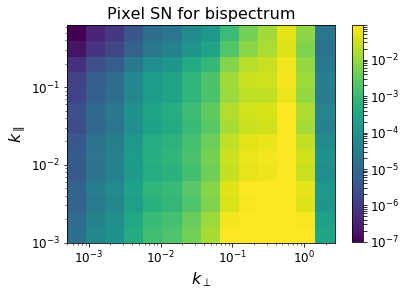

In [53]:
import pylab

print kperp_arr_snr

print SNR_arr.min(), SNR_arr.max()
#print (np.cumsum(cum_SNR(SNR_arr)))

pylab.pcolormesh(kperp_arr_snr,kpar_arr_snr,SNR_arr,vmax=0.09,norm=LogNorm());  cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
pylab.xlim([np.min(kperp_arr_snr),np.max(kperp_arr_snr)]) ; pylab.ylim([np.min(kpar_arr_snr),np.max(kpar_arr_snr)])
plt.xlabel(r'$k_\perp$',fontsize=16); plt.ylabel(r'$k_\parallel$',fontsize=16); plt.title('Pixel SN for bispectrum', fontsize=16)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('optimal_SN_2D_bispec_z_1_deltaz_pt2_integrated_over_redshift_kppar_1e-3_1_kpperp_lims__5e-4_1_zksz_full_80pts.png', dpi=300, bbox_inches='tight')
pylab.show()

In [54]:
#np.save('kperp_kpar_ska_z_2_deltaz_pt4_kppar_1e-2_1_kpperp_5e-4_1_kpar_1e-2_1_kperp_5e-4_10_80pts',(kperp_arr_snr,kpar_arr_snr))
#np.save('SNR_2d_ska_z_2_deltaz_pt4_kppar_1e-2_1_kpperp_5e-4_1_kpar_1e-2_1_kperp_5e-4_10_80pts',(SNR_arr))

In [55]:
kperp_low_kpar,kpar_low_kpar=np.load('kperp_kpar_hirax_z_1_deltaz_pt2_kppar_1e-3_1_kpperp_5e-4_1_kpar_1e-3_1_kperp_5e-4_10_80pts.npy')
SNR_2d_low_kpar=np.load('SNR_2d_hirax_z_1_deltaz_pt2_kppar_1e-3_1_kpperp_5e-4_1_kpar_1e-3_1_kperp_5e-4_10_80pts.npy')

In [56]:
kperp_high_kpar,kpar_high_kpar=np.load('kperp_kpar_hirax_z_1_deltaz_pt2_kppar_1e-2_1_kpperp_5e-4_1_kpar_1e-2_1_kperp_5e-4_10_80pts.npy')
SNR_2d_high_kpar=np.load('SNR_2d_hirax_z_1_deltaz_pt2_kppar_1e-2_1_kpperp_5e-4_1_kpar_1e-2_1_kperp_5e-4_10_80pts.npy')

In [57]:
kperp_low_kpar_z_2,kpar_low_kpar_z_2=np.load('kperp_kpar_hirax_z_2_deltaz_pt4_kppar_1e-3_1_kpperp_5e-4_1_kpar_1e-3_1_kperp_5e-4_10_80pts.npy')
SNR_2d_low_kpar_z_2=np.load('SNR_2d_hirax_z_2_deltaz_pt4_kppar_1e-3_1_kpperp_5e-4_1_kpar_1e-3_1_kperp_5e-4_10_80pts.npy')

In [58]:
kperp_high_kpar_z_2,kpar_high_kpar_z_2=np.load('kperp_kpar_hirax_z_2_deltaz_pt2_kppar_1e-2_1_kpperp_5e-4_1_kpar_1e-2_1_kperp_5e-4_10_80pts.npy')
SNR_2d_high_kpar_z_2=np.load('SNR_2d_hirax_z_2_deltaz_pt2_kppar_1e-2_1_kpperp_5e-4_1_kpar_1e-2_1_kperp_5e-4_10_80pts.npy')

In [59]:
kperp_low_kpar_z_1_ska,kpar_low_kpar_z_1_ska=np.load('kperp_kpar_ska_z_1_deltaz_pt2_kppar_1e-3_1_kpperp_5e-4_1_kpar_1e-3_1_kperp_5e-4_10_80pts.npy')
SNR_2d_low_kpar_z_1_ska=np.load('SNR_2d_ska_z_1_deltaz_pt2_kppar_1e-3_1_kpperp_5e-4_1_kpar_1e-3_1_kperp_5e-4_10_80pts.npy')

In [60]:
kperp_high_kpar_z_1_ska,kpar_high_kpar_z_1_ska=np.load('kperp_kpar_ska_z_1_deltaz_pt2_kppar_1e-2_1_kpperp_5e-4_1_kpar_1e-2_1_kperp_5e-4_10_80pts.npy')
SNR_2d_high_kpar_z_1_ska=np.load('SNR_2d_ska_z_1_deltaz_pt2_kppar_1e-2_1_kpperp_5e-4_1_kpar_1e-2_1_kperp_5e-4_10_80pts.npy')

In [61]:
kperp_low_kpar_z_2_ska,kpar_low_kpar_z_2_ska=np.load('kperp_kpar_ska_z_2_deltaz_pt4_kppar_1e-3_1_kpperp_5e-4_1_kpar_1e-3_1_kperp_5e-4_10_80pts.npy')
SNR_2d_low_kpar_z_2_ska=np.load('SNR_2d_ska_z_2_deltaz_pt4_kppar_1e-3_1_kpperp_5e-4_1_kpar_1e-3_1_kperp_5e-4_10_80pts.npy')

In [62]:
kperp_high_kpar_z_2_ska,kpar_high_kpar_z_2_ska=np.load('kperp_kpar_ska_z_2_deltaz_pt4_kppar_1e-2_1_kpperp_5e-4_1_kpar_1e-2_1_kperp_5e-4_10_80pts.npy')
SNR_2d_high_kpar_z_2_ska=np.load('SNR_2d_ska_z_2_deltaz_pt4_kppar_1e-2_1_kpperp_5e-4_1_kpar_1e-2_1_kperp_5e-4_10_80pts.npy')

In [63]:
def cumulative_SNR(SNR_2D_binned):
    sum_each_kperp=np.array([])
    SNR_y,SNR_x=SNR_2D_binned.shape
    for i in range(SNR_x):
        sum_one_kperp=np.sum(SNR_2D_binned[:,i])
        sum_each_kperp=np.append(sum_each_kperp,sum_one_kperp)
    return sum_each_kperp

def cumulative_SNR_kpar(SNR_2D_binned):
    sum_each_kpar=np.array([])
    SNR_y,SNR_x=SNR_2D_binned.shape
    for i in range(SNR_x):
        sum_one_kpar=np.sum(SNR_2D_binned[i,:])
        sum_each_kpar=np.append(sum_each_kpar,sum_one_kpar)
    return sum_each_kpar


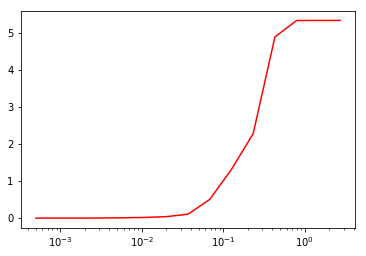

In [64]:
plt.semilogx(kperp_arr_snr,np.cumsum(cumulative_SNR(SNR_arr)),'r')
#plt.semilogx(kperp_arr_snr, np.cumsum(cumulative_SNR(SNR_arr)),'b')


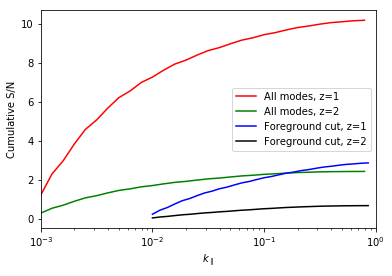

In [65]:
plt.semilogx(kpar_low_kpar,np.cumsum(cumulative_SNR_kpar(SNR_2d_low_kpar)),'r')
plt.semilogx(kpar_low_kpar_z_2, np.cumsum(cumulative_SNR_kpar(SNR_2d_low_kpar_z_2)),'g')
plt.semilogx(kpar_high_kpar, np.cumsum(cumulative_SNR_kpar(SNR_2d_high_kpar)),'b')
plt.semilogx(kpar_high_kpar_z_2, np.cumsum(cumulative_SNR_kpar(SNR_2d_high_kpar_z_2)),'k')


plt.ylabel('Cumulative S/N')
plt.xlabel(r'$k_\parallel$')
plt.legend(('All modes, z=1','All modes, z=2', 'Foreground cut, z=1','Foreground cut, z=2'))
plt.xlim(1e-3,1)
#plt.savefig('optimal_cumSN__kpar_hirax_cuts_z_1_2.png', dpi=300, bbox_inches='tight')
plt.show()

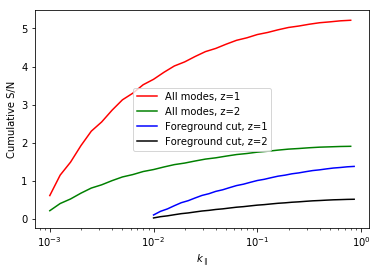

In [66]:
plt.semilogx(kpar_low_kpar_z_1_ska,np.cumsum(cumulative_SNR_kpar(SNR_2d_low_kpar_z_1_ska)),'r')
plt.semilogx(kpar_low_kpar_z_2_ska, np.cumsum(cumulative_SNR_kpar(SNR_2d_low_kpar_z_2_ska)),'g')
plt.semilogx(kpar_high_kpar_z_1_ska, np.cumsum(cumulative_SNR_kpar(SNR_2d_high_kpar_z_1_ska)),'b')
plt.semilogx(kpar_high_kpar_z_2_ska, np.cumsum(cumulative_SNR_kpar(SNR_2d_high_kpar_z_2_ska)),'k')


plt.ylabel('Cumulative S/N')
plt.xlabel(r'$k_\parallel$')
plt.legend(('All modes, z=1','All modes, z=2', 'Foreground cut, z=1','Foreground cut, z=2'))
#plt.xlim(1.18e-2,1)
#plt.savefig('optimal_cumSN_hirax_cuts_z_1_2.png', dpi=300, bbox_inches='tight')
plt.show()

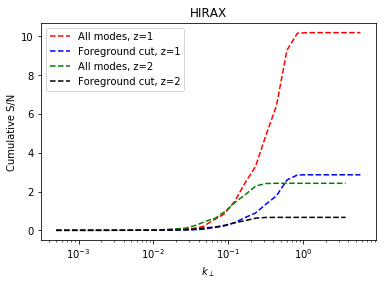

In [67]:
plt.semilogx(kperp_low_kpar_z_1_ska, np.cumsum(cumulative_SNR(SNR_2d_low_kpar)),'r--')
plt.semilogx(kperp_high_kpar_z_1_ska, np.cumsum(cumulative_SNR(SNR_2d_high_kpar)),'b--')


plt.semilogx(kperp_low_kpar_z_2_ska, np.cumsum(cumulative_SNR(SNR_2d_low_kpar_z_2)),'g--')
plt.semilogx(kperp_high_kpar_z_2_ska, np.cumsum(cumulative_SNR(SNR_2d_high_kpar_z_2)),'k--')

plt.ylabel('Cumulative S/N')
plt.xlabel(r'$k_\perp$')
plt.legend(('All modes, z=1','Foreground cut, z=1','All modes, z=2','Foreground cut, z=2'))
plt.title('HIRAX')
#plt.xlim(1.18e-2,1)
#plt.savefig('optimal_cumSN_hirax_cuts_z_1_2.png', dpi=300, bbox_inches='tight')
plt.show()

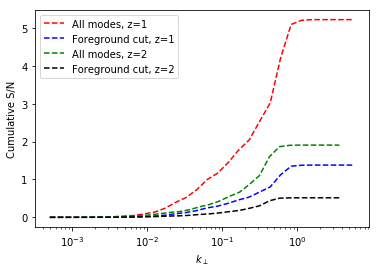

In [68]:
plt.semilogx(kperp_low_kpar_z_1_ska, np.cumsum(cumulative_SNR(SNR_2d_low_kpar_z_1_ska)),'r--')
plt.semilogx(kperp_high_kpar_z_1_ska, np.cumsum(cumulative_SNR(SNR_2d_high_kpar_z_1_ska)),'b--')


plt.semilogx(kperp_low_kpar_z_2_ska, np.cumsum(cumulative_SNR(SNR_2d_low_kpar_z_2_ska)),'g--')
plt.semilogx(kperp_high_kpar_z_2_ska, np.cumsum(cumulative_SNR(SNR_2d_high_kpar_z_2_ska)),'k--')

plt.ylabel('Cumulative S/N')
plt.xlabel(r'$k_\perp$')
plt.legend(('All modes, z=1','Foreground cut, z=1','All modes, z=2','Foreground cut, z=2'))
#plt.title('SKA1-MID')
#plt.xlim(1.18e-2,1)
#plt.savefig('optimal_cumSN_ska_cuts_z_1_2.png', dpi=300, bbox_inches='tight')
plt.show()